# Libraries

In [1]:
import pandas as pd
import numpy as np

# Plotting Libs
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree
from xgboost import plot_importance
import seaborn as sns

# Statistical Libs
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import warnings

# Collinearity / Feature Selection Libs 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import Binarizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import zero_one_loss
from sklearn.decomposition import PCA

# Model Libs
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier

# Accuracy Libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import learning_curve

# Resampling Libs
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler



# Load Data

In [ ]:
df0 = pd.read_pickle(r".\df_dummies\df0_dummies.pkl")
df1 = pd.read_pickle(r".\df_dummies\df1_dummies.pkl")
df2 = pd.read_pickle(r".\df_dummies\df2_dummies.pkl")
df3 = pd.read_pickle(r".\df_dummies\df3_dummies.pkl")
df4 = pd.read_pickle(r".\df_dummies\df4_dummies.pkl")
df5 = pd.read_pickle(r".\df_dummies\df5_dummies.pkl")
df = pd.read_pickle(r".\df_dummies\df_dummies.pkl")


## Df Input

In [3]:
i = 1
dfi = df1

# Data Preperation

In [ ]:
X = dfi.drop("Study Status", axis = 1)
y = dfi["Study Status"]

# initial X features
X.shape[1]

# Accuracy tests/ Roc Function


In [259]:
def accuracy(dfi, i, model, X_test, y_test, y_pred, title):
    print(f"Model : Phase {i} - {title}")
    
    print("\na).\nAccuracy Score : (True P + True N) / N total :")
    print(f"{accuracy_score(y_test, y_pred) * 100:.2f}%")

    print("\nb).\nClassification Report :")
    print(classification_report(y_test, y_pred))

    print("\nc).\nPlots :")
    fig , ax = plt.subplots(figsize = (20, 4), nrows = 1, ncols = 2)
    ConfusionMatrixDisplay.from_predictions(y_test , y_pred, ax = ax[0]);
    RocCurveDisplay.from_estimator(model, X_test, y_test, pos_label = 1, ax = ax[1], name = f'{title}'); 

    print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]).round(2))
    plt.suptitle(f"Phase {i} - {title}", fontsize = 11, fontweight = 'bold')

    ax[0].set_title("1. Confusion Matrix", fontsize = 10, fontweight = 'bold')
    ax[0].set_xlabel("Predicted Label", fontsize = 10, fontweight = 'bold')
    ax[0].set_ylabel("True Label", fontsize = 10, fontweight = 'bold')
    #ax[0].set_xticklabels(["Terminated", "Completed"], fontsize = 10, fontweight = 'bold')
    #ax[0].set_yticklabels(["Terminated", "Completed"], fontsize = 10, fontweight = 'bold')

    ax[1].set_title("2. ROC Curve" , fontsize = 10, fontweight = 'bold')
    ax[1].set_xlabel("True Positive Rate (Completed)", fontsize = 10, fontweight = 'bold')
    ax[1].set_ylabel("False Positive Rate (Completed)", fontsize = 10, fontweight = 'bold')

# Feature Selection

- X_train/X_test used based in Resample/Feature Selection based on the model used. 

Model	               VarThres	       VIF?	      Scaling?	   Resample?	Lasso (L1)?   Feature Selection
Logistic Regression	   ✅ Yes	     ✅ Yes	    ✅ Yes	  ✅ Yes	     ✅ Op           Lasso / VIF
ElasticNet/Lasso	   ✅ Yes	     ❌ Op	    ✅ Yes	  ✅ Yes	     ❌ No           Built-in (L1/L2)
Random Forest	       ✅ Yes	     ❌ No	    ❌ No	  ✅ Yes	     ❌ No           Optional (by importance)
XGBoost / LightGBM	   ✅ Yes	     ❌ No	    ❌ No	  ✅ Yes	     ❌ No           Optional

Step	Action	Required?	Applies to
1️⃣	Train-test split	        ✅	All
2️⃣	VarianceThreshold	        ✅	All
3️⃣	Mutual Information	        ✅	All
4️⃣	VIF (skip if used Lasso)	🔁   Maybe	GLM only
5️⃣	Resampling (SMOTE)	        
6️⃣	Scaling	                    ✅	Needed for Lasso
7️⃣	Lasso	                    ✅	GLM, ML
8️⃣	Use selected features	    ✅	All models

## Train-Test Split, Scale Data

In [260]:
# Train-Test Split
def fun_train_test_split(X_tts_par, y_tts_par):  # function that also uses y
    X_train, X_test, y_train, y_test = train_test_split(X_tts_par, y_tts_par, test_size = 0.3, random_state = 42)
    return X_train, X_test, y_train, y_test

## VarianceThreshold
- Feature selector that removes all low-variance features.

In [261]:
def fun_var_thres(X_train_vt_par, X_test_vt_par):
    '''variances = X_train_vt_par.var()
    plt.figure(figsize = (8, 2))
    plt.hist(variances, bins = 25)
    plt.axvline(x = 0.01, color = 'red', linestyle = '--', label = 'Suggested Threshold = 0.01') 
    plt.title('Feature Variance Distribution')
    plt.xlabel('Variance')
    plt.ylabel('Number of Features')
    plt.legend()'''
    vt = VarianceThreshold(threshold = 0.01)
    # threshold = 0.01: 
    # Binary variables (0, 1) --> removes variables where one class dominates more than ~99% of the time.
    # Continuous variables --> removes those that barely vary across samples (e.g., nearly constant).
    vt = vt.fit(X_train_vt_par)
    # X_train_vt_array = vt.fit_transform(X_test_vt_par) # Values of X (Array). No naming of X

    X_train_vt = X_train_vt_par.loc[:, vt.get_support()] # .loc[:, get support] -->  gives df, not array that tranform gives
    X_test_vt = X_test_vt_par[X_train_vt.columns]

    return X_train_vt, X_test_vt



## MI 

In [262]:
def fun_mi(X_train_mi_par, X_test_mi_par, y_train_mi_par, k = 'all'): # used y

    X_kept = SelectKBest(score_func = mutual_info_classif, k = k)
    X_train_mi = X_kept.fit_transform(X_train_mi_par, y_train_mi_par)

    mask = X_kept.get_support()
    selected_features = X_train_mi_par.columns[mask].tolist()

    X_test_mi = X_kept.transform(X_test_mi_par)

    X_train_mi = pd.DataFrame(X_train_mi, columns = selected_features, index = X_train_mi_par.index)
    X_test_mi = pd.DataFrame(X_test_mi, columns = selected_features, index = X_test_mi_par.index)

    mi_scores = pd.Series(X_kept.scores_, index = X_train_mi_par.columns).sort_values(ascending=False)

    return X_train_mi, X_test_mi, mi_scores

## VIF --> good for multicoll sensitive models (QDA, LDA) 
** Documentation notes
- Variance inflation factor is a measure for the increase of the variance of the parameter estimates if an additional variable is added to the linear regression. 
- It is a measure for multicollinearity.
- One recommendation is that if VIF is > 5, then the explanatory variable is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.
- For linear collinearity only.


In [263]:
# VIF --> good for multicoll sensitive models (QDA, LDA) Function
def fun_vif(X_train_vif_par, X_test_vif_par):  # apply only on X_train
    X_train_vif_par = X_train_vif_par.astype(float)
    X_test_vif_par = X_test_vif_par.astype(float)
    
    vif = pd.DataFrame()
    vif["Features"] = X_train_vif_par.columns
    vif["VIF"] = [variance_inflation_factor(X_train_vif_par.values, i) for i in range(X_train_vif_par.shape[1])]

    X_vhigh_inf = vif[(vif['VIF'] == float('inf')) | (vif['VIF'] >= 5)]['Features'].tolist()
    X_kept_vif = X_train_vif_par.drop(columns = X_vhigh_inf)

    vif = pd.DataFrame()
    vif["Features"] = X_kept_vif.columns
    vif["VIF"] = [variance_inflation_factor(X_kept_vif.values, i) for i in range(X_kept_vif.shape[1])]
    vif = vif.sort_values(by="VIF", ascending=False)

    X_train_vif = X_train_vif_par[X_kept_vif.columns]
    X_test_vif = X_test_vif_par[X_kept_vif.columns]
    
    return X_train_vif, X_test_vif


## Resample 
- Datasets are imbalanced towards the positive class. (i.e. COMPLETED = 1)
- Resample train set only, so model will be correctly trained (not biased towards the most common category of Study Status).
    --> Avoids information leaking to test set. test set always similar to true cases.
- Performance evaluated on unsampled test set, with real data percentages per category.
 

In [264]:
def fun_resample(X_train_res_par, y_train_res_par): # function that also uses y # Always resample after dataset split

    res = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train_res, y_train_res = res.fit_resample(X_train_res_par, y_train_res_par) 
    return X_train_res, y_train_res


## Scaling

In [265]:
# Scale continuous/log variables
def fun_scale(X_train_sc_par, X_test_sc_par):  # Scaling always after dataset split

    X_train_sc = X_train_sc_par.copy()
    X_test_sc = X_test_sc_par.copy()

    cont_cols = [col for col in X_train_sc.columns 
                    if (('count' in col.lower() or 'log' in col.lower()) and
                        not any(x in col.lower() for x in ['bin', 'categ', 'list']))]
    if cont_cols:
        scaler = StandardScaler(with_mean = False, with_std = True)

        X_train_sc[cont_cols] = pd.DataFrame(scaler.fit_transform(X_train_sc[cont_cols]),
            columns = cont_cols, index=X_train_sc.index)

        X_test_sc[cont_cols] = pd.DataFrame(scaler.transform(X_test_sc[cont_cols]),
            columns = cont_cols, index=X_test_sc.index)
    else:
        print("No continuous/log columns to scale.")

    return X_train_sc, X_test_sc


## Lasso (L1 Regularization)
- Feature selection + regularization 
- No (linear only)       
- Biased in presence of high correlation 

In [266]:
def fun_lasso(X_train_la_par, X_test_la_par, y_train_la_par):    # lasso surely after dataset split (model built in method)
        
    log_cv = LogisticRegressionCV(
    Cs = 10,   # 10 C values (inverse regularization strength C = 1/λ)
    cv = 5,                            
    penalty = 'l1',                    
    solver = 'saga',                   
    scoring = 'accuracy',             
    max_iter = 8000,
    random_state = 42)

    log_cv.fit(X_train_la_par, y_train_la_par)
# infinite scores exclusion
    coefs = log_cv.coef_.flatten()
    mask_finite = np.isfinite(coefs)
    fixed_coefs = np.where(mask_finite, coefs, 0).reshape(1, -1)
    log_cv.coef_ = fixed_coefs

    selector = SelectFromModel(log_cv, prefit = True, threshold=1e-5)  # prefix = True --> model already fitted. Choose from its coefs.
    # '1e-5' keep all vars except those too close/equal to 0 coef
    X_Kept_la = X_train_la_par.columns[selector.get_support()] # Get a mask, or integer index, of the features selected.

    X_train_la = pd.DataFrame(selector.transform(X_train_la_par), 
                              columns = X_Kept_la, index = X_train_la_par.index) # train data already fitted through log_cv above.
    X_test_la = pd.DataFrame(selector.transform(X_test_la_par), 
                             columns = X_Kept_la, index = X_test_la_par.index)
    
    return X_train_la, X_test_la


## PCA
- Only after scale

In [267]:
def fun_pca(X_train_pca_par, X_test_pca_par, pca_components = None):
    pca = PCA(n_components = pca_components)
    X_train_pca = pca.fit_transform(X_train_pca_par)
    X_test_pca = pca.transform(X_test_pca_par)

    return X_train_pca, X_test_pca

## Function Combined
- VIF lowers AUC scores when used.

In [ ]:
'''## Split -> VarThres -> VIF -> Resample -> Scale -> Lasso 
def fun_feat_sel(vt, mi, vif, la, pca):
# X, y
    X = dfi.drop("Study Status", axis = 1)
    y = dfi["Study Status"]
    X_par = X.copy()
    y_par = y.copy()

    # Train test Split (+ y_train_par) (will be done wither way)
    X_tts_par = X_par.copy()    # upper params always X_train_par to the right
    y_tts_par = y_par.copy()

    X_train_tts, X_test_tts, y_train_tts, y_test = fun_train_test_split(X_tts_par, y_tts_par)

    X_train_par = X_train_tts.copy()      # lower params always X_train_par to the left
    X_test_par = X_test_tts.copy()
    y_train_par = y_train_tts.copy()

# ====================================================================
# var Thres
    if vt == True:
        X_train_vt_par = X_train_par.copy()
        X_test_vt_par = X_test_par.copy()

        X_train_vt , X_test_vt = fun_var_thres(X_train_vt_par, X_test_vt_par)

        X_train_par = X_train_vt.copy()
        X_test_par = X_test_vt.copy()
   
# MI (+ y_train_par)
    if mi == True:
        X_train_mi_par = X_train_par.copy()
        X_test_mi_par = X_test_par.copy()
        y_train_mi_par = y_train_par.copy()

        X_train_mi, X_test_mi, mi_scores = fun_mi(X_train_mi_par, X_test_mi_par, y_train_mi_par)

        X_train_par = X_train_mi.copy()
        X_test_par = X_test_mi.copy()

# VIF --> good for multicoll sensitive models (QDA, LDA)
    if vif == True:
        X_train_vif_par = X_train_par.copy()
        X_test_vif_par = X_test_par.copy()

        X_train_vif, X_test_vif = fun_vif(X_train_vif_par, X_test_vif_par)

        X_train_par = X_train_vif.copy()
        X_test_par = X_test_vif.copy()

# ====================================================================
# Resample (+ y_train_par) (will be done either way)
    X_train_res_par = X_train_par.copy()
    y_train_res_par = y_train_par.copy()

    X_train_res, y_train_res = fun_resample(X_train_res_par, y_train_res_par)

    X_train_par = X_train_res.copy()
    y_train_par = y_train_res.copy()

# Scaling (will be done either way)
    X_train_sc_par = X_train_par.copy()
    X_test_sc_par = X_test_par.copy()  

    X_train_sc, X_test_sc = fun_scale(X_train_sc_par, X_test_sc_par)

    X_train_par = X_train_sc.copy()
    X_test_par = X_test_sc.copy()

# ====================================================================
# Lasso
    if la == True:
        X_train_la_par = X_train_par.copy()
        X_test_la_par = X_test_par.copy()
        y_train_la_par = y_train_par.copy()

        X_train_la, X_test_la = fun_lasso(X_train_la_par, X_test_la_par, y_train_la_par)

        X_train_par = X_train_la.copy()
        X_test_par = X_test_la.copy()
# pca
    if pca == True:
        X_train_pca_par = X_train_par.copy()
        X_test_pca_par = X_test_par.copy()

        X_train_pca, X_test_pca = fun_pca(X_train_pca_par, X_test_pca_par)

        X_train_par = X_train_pca.copy()
        X_test_par = X_test_pca.copy() 
        
# ====================================================================
    X_train = X_train_par.copy()
    X_test = X_test_par.copy()
    y_train = y_train_par.copy()
    
    X_Kept_df = pd.DataFrame(X_train_par.columns.tolist(), columns = ['X_selected'])
    return X_train, X_test, y_train, y_test, X_Kept_df'''



# Number of Feature check

In [ ]:
'''def combined_bias_variance_plot(X, y, max_features = 40, step = 3, cv = 5):
    train_errors_lasso = []
    val_errors_lasso = []
    train_errors_mi = []
    val_errors_mi = []
    num_features = []

    for k in range(1, max_features + 1, step):
        # LASSO selection
        base_model = LogisticRegression(
            penalty='l1', solver='saga', max_iter=5000, random_state=42, class_weight='balanced', n_jobs = -1)
        base_model.fit(X, y)
        selector_lasso = SelectFromModel(base_model, prefit=True, max_features=k, threshold=-np.inf)
        X_lasso = selector_lasso.transform(X)

        model_lasso = LogisticRegression(
            penalty='l2', solver='lbfgs', max_iter=5000, random_state=42, class_weight='balanced', n_jobs = -1)
        model_lasso.fit(X_lasso, y)
        train_preds_lasso = model_lasso.predict(X_lasso)
        train_error_lasso = 1 - np.mean(train_preds_lasso == y)
        val_score_lasso = cross_val_score(model_lasso, X_lasso, y, cv=cv, scoring='accuracy')
        val_error_lasso = 1 - val_score_lasso.mean()

        # Mutual Information selection
        selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
        X_mi = selector_mi.fit_transform(X, y)

        model_mi = LogisticRegression(
            penalty='l2', solver='lbfgs', max_iter=5000, random_state=42, class_weight='balanced', n_jobs = -1)
        model_mi.fit(X_mi, y)
        train_preds_mi = model_mi.predict(X_mi)
        train_error_mi = 1 - np.mean(train_preds_mi == y)
        val_score_mi = cross_val_score(model_mi, X_mi, y, cv=cv, scoring='accuracy')
        val_error_mi = 1 - val_score_mi.mean()

        # Append results
        num_features.append(k)
        train_errors_lasso.append(train_error_lasso)
        val_errors_lasso.append(val_error_lasso)
        train_errors_mi.append(train_error_mi)
        val_errors_mi.append(val_error_mi)

    # Plotting
    plt.figure(figsize=(20, 4))
    plt.plot(num_features, train_errors_lasso, label='Lasso - Train Error', marker='o')
    plt.plot(num_features, val_errors_lasso, label='Lasso - Validation Error', marker='s')
    plt.plot(num_features, train_errors_mi, label='MI - Train Error', marker='^')
    plt.plot(num_features, val_errors_mi, label='MI - Validation Error', marker='v')
    plt.xticks(range(min(num_features), max(num_features) + 1, step))
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Classification Error (0-1 Loss)')
    plt.title('Bias-Variance Tradeoff: Lasso vs Mutual Information')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
combined_bias_variance_plot(X_train, y_train, max_features=119, step=3)
# Warnings Regarding:
# 1. SelectKBest --> always gives the warning
# 2. Lasso plot itself gives less features equal to selected ones (Thus plots X scale max point) than all X.shape[1] features of 
# intial dataset.
# However, MI plot can include all in its plot. Errors about the X sclae that is going to be altered to all X.shape[1] scale for 
# despite including also the lasso plot.
# 
# 
# # Example if function called:
X_train_log, X_test_log, y_train, y_test, X_Kept_df = fun_feat_sel(vt = False, mi = False, vif = False, la = True, pca = False)
X_train = X_train_log.copy()
X_test = X_test_log.copy()'''

"def combined_bias_variance_plot(X, y, max_features = 40, step = 3, cv = 5):\n    train_errors_lasso = []\n    val_errors_lasso = []\n    train_errors_mi = []\n    val_errors_mi = []\n    num_features = []\n\n    for k in range(1, max_features + 1, step):\n        # LASSO selection\n        base_model = LogisticRegression(\n            penalty='l1', solver='saga', max_iter=5000, random_state=42, class_weight='balanced', n_jobs = -1)\n        base_model.fit(X, y)\n        selector_lasso = SelectFromModel(base_model, prefit=True, max_features=k, threshold=-np.inf)\n        X_lasso = selector_lasso.transform(X)\n\n        model_lasso = LogisticRegression(\n            penalty='l2', solver='lbfgs', max_iter=5000, random_state=42, class_weight='balanced', n_jobs = -1)\n        model_lasso.fit(X_lasso, y)\n        train_preds_lasso = model_lasso.predict(X_lasso)\n        train_error_lasso = 1 - np.mean(train_preds_lasso == y)\n        val_score_lasso = cross_val_score(model_lasso, X_lasso, y

# Models

## Prepare Data
TTS --> VT --> MI --> VIF --> Res --> Scale --> Lasso --> PCA

In [ ]:
# X,y 
X = dfi.drop("Study Status", axis = 1)
y = dfi["Study Status"]

## A) Classic Classification

### Logistic Regression (Lasso Regularization)
- C = 1/λ = Positive float. Default = 1 Inverse of regularization strength. 
- Stronger regularization --> smaller coefs.

- Small C (e.g. 0.001) --> Strong regularization   --> More bias, smaller coefficients (simpler model)
- Large C (e.g. 1000)  --> Weak regularization     --> Model fits more to data (can overfit)
- C = 1 (default)      --> Moderate regularization --> Balanced by default



C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


126

Model : Phase 1 - Lasso Logistic Regression (L1)

a).
Accuracy Score : (True P + True N) / N total :
78.72%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      6397
           1       0.44      0.79      0.57      1371

    accuracy                           0.79      7768
   macro avg       0.69      0.79      0.71      7768
weighted avg       0.86      0.79      0.81      7768


c).
Plots :
0.87


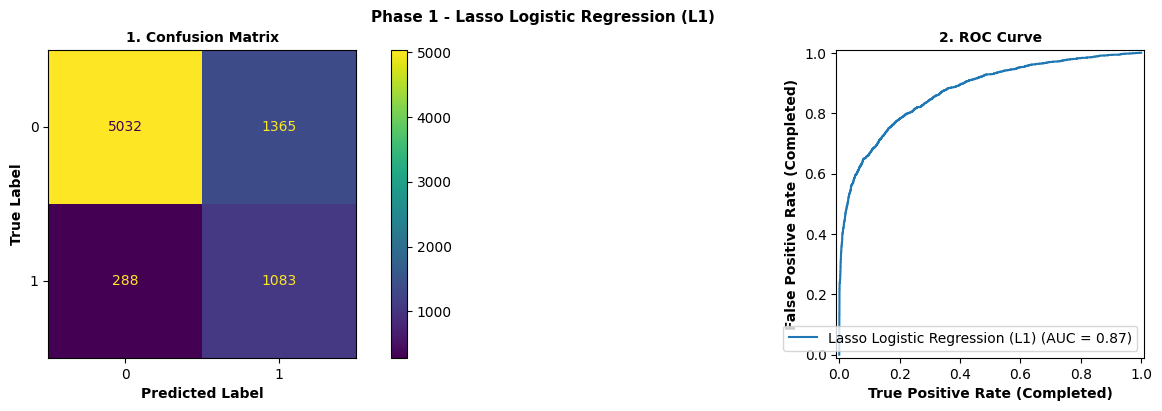

In [ ]:
# Split -> VarThres -> VIF -> Resample -> Scale -> lasso
# Same AUC score with mi|la.
# Less AUC score as more the feature selection methods used. 
# Do not mute the warning --> Won't notice if any coefs did not converge.
# Warning regarding SelectFromModel method od fit. 
X_train, X_test, y_train, y_test = fun_train_test_split(X, y)
X_train, y_train = fun_resample(X_train, y_train)
X_train, X_test = fun_scale(X_train, X_test)
X_train, X_test = fun_lasso(X_train, X_test, y_train)

display(X_train.shape[1])


In [ ]:
# Model
log_reg = LogisticRegression(max_iter = 5000 , solver = 'saga', class_weight = 'balanced',  random_state = 42)  
# Final Model
log_model = log_reg.fit(X_train, y_train)
# y_pred
y_pred_log_l1 = log_model.predict(X_test)
# Accuracy Score
accuracy(dfi, i, log_model, X_test, y_test, y_pred_log_l1, "Lasso Logistic Regression (L1)")

### LDA - Linear Discriminant Analysis

QDA and LDA assume Gaussian distributions.

Best Parameters : {'n_components': 1, 'shrinkage': 0.223}
Best Estimator : LinearDiscriminantAnalysis(n_components=1, shrinkage=0.223, solver='lsqr',
                           store_covariance=True)
Model : Phase 1 - Linear Discriminant Analysis (LDA)

a).
Accuracy Score : (True P + True N) / N total :
79.34%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      6397
           1       0.45      0.78      0.57      1371

    accuracy                           0.79      7768
   macro avg       0.70      0.79      0.72      7768
weighted avg       0.86      0.79      0.81      7768


c).
Plots :
0.87


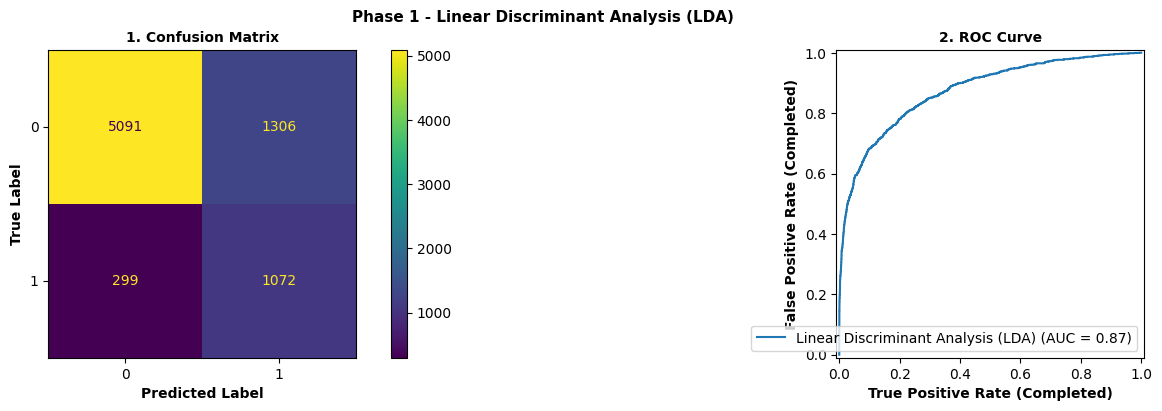

In [ ]:
# Split -> VarThres -> VIF -> Resample -> Scale 
# X_train, X_test, y_train, y_test, X_Kept_df = fun_feat_sel(vt = False, mi = False, vif = False, la = True, pca = False)
# The error:  vif = 1. / (1. - r_squared_i) --> Fixed through exclusion of inf vif score features
# =============================================================================================================

# Model
lda = LDA(store_covariance = True, solver = 'lsqr') # Use solver = lsqr if cv needed.

# Grid Search CV
param_grid = {
    "shrinkage" : [None, "auto"] + list(np.linspace(0.001, 1, 10)), 
    'n_components' : np.arange(1, min(X_train.shape[1], len(np.unique(y_train)) - 1) + 1)
    } 
lda_grid = GridSearchCV(lda, param_grid = param_grid, cv = 5) # cv = 5 default

# Final Model
lda_model = lda_grid.fit(X_train, y_train)
print(f'Best Parameters : {lda_model.best_params_}')
print(f'Best Estimator : {lda_model.best_estimator_}')

# y_pred
y_pred_lda = lda_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, lda_model, X_test, y_test, y_pred_lda, "Linear Discriminant Analysis (LDA)")


### QDA - Quantratic Discriminant Analysis
- QDA very sensistive to collinear data!
QDA and LDA assume Gaussian distributions.

In [272]:
# VIF --> Lasso --> Model (1+min)
X_train_log, X_test_log, y_train, y_test, X_Kept_df = fun_feat_sel(vt = False, mi = False, vif = False, la = True, pca = True)
X_train = X_train_log.copy()
X_test = X_test_log.copy()

display(X_train.shape[1])
print(y_train.value_counts(normalize = False), y_test.value_counts(normalize = False))

# Warning: Not an error --> warning that vif found an inf.
# A col almost linear associated with other cols. (high multicollinearity).
# The feature is too constant. (Same across categories)
# There are similar (almost same columns/copy_cols)

# =============================================================================================================

# Split -> VarThres -> VIF -> Resample -> Scale 
X_train, X_test, y_train, y_test, X_Kept_df = fun_feat_sel(vt = False, mi = False, vif = False, la = True, pca = True)
# VIF still pops collinearity error when used
X_train_qda = X_train_log.copy()
X_test_qda = X_test_log.copy()
X_train = X_train_qda.copy()
X_test = X_test_qda.copy()

# Model
qda = QDA(store_covariance = True)

# GridSearch
param_grid = {
    "reg_param": np.linspace(0, 1, 20)
    }
qda_grid = GridSearchCV(qda, param_grid = param_grid, cv = 5) # cv = 5 default

# Final model
qda_model = qda_grid.fit(X_train, y_train)
display(f'Best Parameters : {qda_model.best_params_}')
display(f'Best Estimator : {qda_model.best_estimator_}')

# y_pred
y_pred_qda = qda_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, qda_model, X_test, y_test, y_pred_qda, "Quantric Discriminant Analysis (QDA)")

C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### Elastic Net Logistic Regression
- l1_ratio = ratio l1 / l2. 
- l1_ratio = 1 = lasso (l1). 
- l1_ratio = 0 = Ridge (l2) . 
- l1_ratio = 0 < l1_ratio < 1 = elastic net

In [ ]:
# Split -> VarThres -> VIF -> Resample -> Scale (L2 handles multicoll.)
# lasso not needed --> built in Elastic Net
X_train_el, X_test_el, y_train, y_test, X_Kept_df = fun_feat_sel(vt = False, mi = False, vif = False, la = False, pca = False)
X_train = X_train_el.copy() 
X_test = X_test_el.copy()

# =============================================================================================================
# Model (2+mins)
log_el = LogisticRegression(penalty = 'elasticnet', max_iter = 3000, solver = "saga", random_state = 42)   

# Grid Search
param_grid = {
    "l1_ratio" : np.linspace(0.1, 1, 10, endpoint = True)
    } 
log_el_grid = GridSearchCV(log_el, param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
log_el_model = log_el_grid.fit(X_train, y_train)  
display(f'Best Parameters : {log_el_model.best_params_}')
display(f'Best Estimator : {log_el_model.best_estimator_}')

# y_pred
y_pred_log_el = log_el_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, log_el_model, X_test, y_test, y_pred_log_el, "Elastic Net Logistic Regression")

## B) ML Classification

### KNN - K Nearest Neighbors

In [ ]:
# Split -> VarThres -> Resample -> Scale
X_train_knn, X_test_knn, y_train, y_test , X_Kept_df = fun_feat_sel(vt = False, vif = False, mi = False, la = False, pca = False)
X_train = X_train_knn.copy()
X_test = X_test_knn.copy()

# =============================================================================================================
# Model (1+min)
knn = KNeighborsClassifier()

# Grid Search
param_grid = {
    "n_neighbors" : np.linspace(1, 100, 100, endpoint = True).astype(int)
    } 

# CV
knn_grid = GridSearchCV(knn , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
knn_model = knn_grid.fit(X_train, y_train)
display(f'Best Parameters : {knn_model.best_params_}')
display(f'Best Estimator : {knn_model.best_estimator_}')

# y_pred
y_pred_knn = knn_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, knn_model, X_test, y_test, y_pred_knn, "K-Nearest Neighbors Classifier (KNN)")

### SVC - Support Vector Classifier

In [ ]:
# Split -> VarThres -> Resample -> Scale
X_train_svc, X_test_svc, y_train, y_test , X_Kept_df = fun_feat_sel(vt = False, vif = False, mi = False, la = False, pca = False)

X_train = X_train_svc.copy()
X_test = X_test_svc.copy()

# =============================================================================================================
# Model (10+mins)
svc = SVC(probability = True, random_state = 42)

# Hyperparameters CV
param_grid = [
    {"kernel": ["linear"]},
    {"kernel": ["rbf"]},
    {"kernel": ["sigmoid"]},
    {"kernel": ["poly"], "degree": [2, 3]},
]

# CV
svc_grid = GridSearchCV(svc , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
svc_model = svc_grid.fit(X_train, y_train)
display(f'Best Parameter kernel: {svc_model.best_params_}')
display(f'Best Estimator: {svc_model.best_estimator_}')

# y_pred
y_pred_svc = svc_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, svc_model, X_test, y_test, y_pred_svc, "Support Vector Classifier (SVC)")

### Tree (Pruned)
- VarThresh -> Split -> Resample -> RF


In [ ]:
# Split -> VT (optional) -> Resample --> Scale (optional)
X_train_tr, X_test_tr, y_train, y_test, X_Kept_df = fun_feat_sel(vt = False, mi = False, vif = False, la = False, pca = False)
X_train = X_train_tr.copy()
X_test = X_test_tr.copy()

# =============================================================================================================

# cc_alphas values meaningful for dataset
tree = DecisionTreeClassifier(random_state=42)
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
display(ccp_alphas.min(), ccp_alphas.mean(), ccp_alphas.max())

# =============================================================================================================

# Model (3+mins)
tree = DecisionTreeClassifier(random_state = 42)

# Hyperparameters CV
param_grid = {
    'criterion': ['gini', 'entropy'],          # Splitting strategy
    'max_depth': [2, 3, 5, 10, 20, None],  # give small depth as choice # Pre-pruning --> Built in feature Selection
    'min_samples_split': [2, 5, 10],            # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],              # Min samples in a leaf
    'max_features': [None, 'sqrt', 'log2'],     # Max features to consider at each split
    'ccp_alpha': np.linspace(0, np.max(ccp_alphas), 10),             # Post-Pruning --> Cost-complexity parameter
}

# CV
tree_grid = GridSearchCV(tree, param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
tree_model = tree_grid.fit(X_train, y_train)
display(f'Best Parameter criterion/max_depth: {tree_model.best_params_}')
display(f'Best Estimator : {tree_model.best_estimator_}')

# y_pred
y_pred_tree_prune = tree_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, tree_model, X_test, y_test, y_pred_tree_prune, "Decision Tree Classifier")

# Plot Tree
# def plot_final_tree(grid_search_model, X_train, class_names = None, max_depth = None, figsize=(20, 10)):
tree_clf = tree_model.best_estimator_

plt.figure(figsize = (20,8))
plot_tree(
    tree_clf,
    feature_names=X_train.columns,
    class_names = ['Terminated', 'Completed'],
    filled=True,
    rounded=True,
    max_depth = tree_model.best_params_['max_depth'],
    fontsize=10
)
plt.title("Decision Tree from GridSearchCV", fontsize = 14, fontweight = 'bold')
plt.show()

# plot_final_tree(tree_model, X_train, class_names = ['Terminated', 'Completed'], max_depth = tree_model.best_params_['max_depth'])

### Random Forest

"Best Parameter criterion/bootstrap/n_estimators : {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt'}"

"Best Estimator : RandomForestClassifier(bootstrap=False, criterion='entropy', random_state=42)"

Model : Phase 3 - Random Forest Classifier

a).
Accuracy Score : (True P + True N) / N total :
83.19%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      3525
           1       0.52      0.73      0.61       764

    accuracy                           0.83      4289
   macro avg       0.73      0.79      0.75      4289
weighted avg       0.86      0.83      0.84      4289


c).
Plots :
0.87


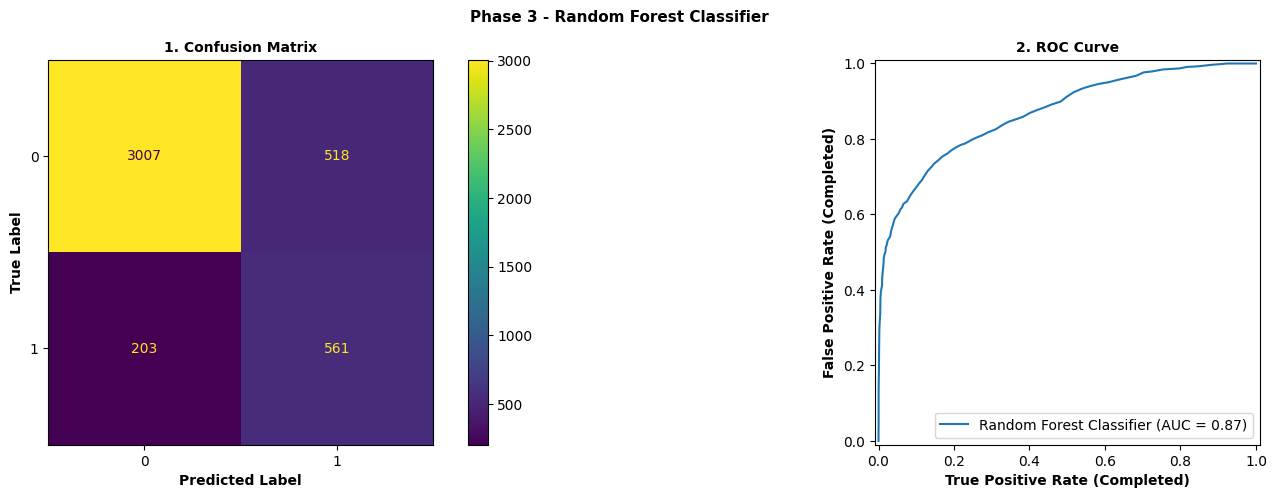

In [ ]:
# Split -> VT (optional) -> Resample --> Scale (optional)
X_train_rf, X_test_rf, y_train, y_test , X_Kept_df = fun_feat_sel(vt = False, vif = False, mi = False, la = False, pca = False)
X_train = X_train_rf.copy()
X_test = X_test_rf.copy()

# Model (1+min)
forest = RandomForestClassifier(random_state = 42)

# Hyperparameters
criterion = ['gini', 'entropy', 'log_loss']
bootstrap = [True, False] # Bootstrap samples when building trees. If False, the whole dataset is used to build each tree.
max_features = ["sqrt", "log2", None]  # None = m = p = Bagging Random Forest. / sqrt = m = sqrt(p) = Classic Random Forest. / log2 = m = log2(p) = Other Random Forest.
param_grid = {
    "criterion" : criterion, "bootstrap" : bootstrap, "max_features" : max_features
    } 

# CV
forest_grid = GridSearchCV(forest , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
forest_model = forest_grid.fit(X_train, y_train)
display(f'Best Parameter criterion/bootstrap/n_estimators : {forest_model.best_params_}')
display(f'Best Estimator : {forest_model.best_estimator_}')

# y_pred
y_pred_forest = forest_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, forest_model, X_test, y_test, y_pred_forest, "Random Forest Classifier")


### Gradient Boosting Classifier

"Best Parameter learning_rate : {'learning_rate': 0.01}"

'Best Estimator : GradientBoostingClassifier(learning_rate=0.01, random_state=42)'

Model : Phase 3 - Gradient Boosting Classifier

a).
Accuracy Score : (True P + True N) / N total :
87.36%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3525
           1       0.67      0.58      0.62       764

    accuracy                           0.87      4289
   macro avg       0.79      0.76      0.77      4289
weighted avg       0.87      0.87      0.87      4289


c).
Plots :
0.85


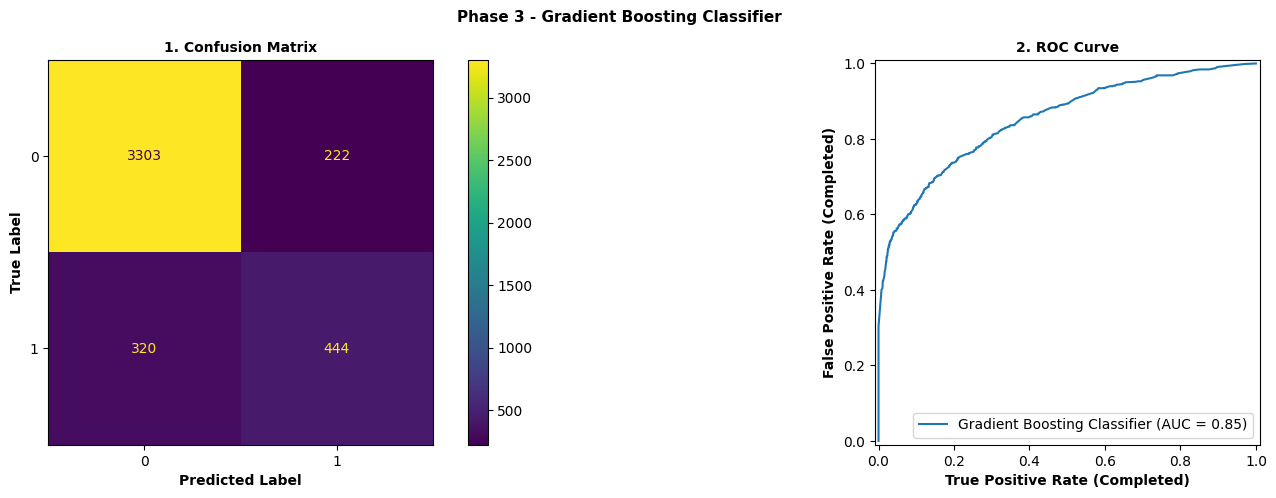

In [ ]:
# Split -> VT (optional) -> Resample --> Scale (optional)
X_train_gb, X_test_gb, y_train, y_test, X_kept_df = fun_feat_sel(vt = False, vif = False, mi = False, la = False, pca = False)
X_train = X_train_gb.copy()
X_test = X_test_gb.copy()

# Model
gra_boost = GradientBoostingClassifier(random_state = 42)  

# Hyperparameters
param_grid = {
    "learning_rate" : np.linspace(0.01, 10, 10, endpoint = True),
    # n_estimators = np.linspace(1000, 10000, 10, endpoint = True).astype(int) # Number of boosting stages to be run. Default = 100.
    }

# CV
gra_boost_grid = GridSearchCV(gra_boost , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
gra_boost_model = gra_boost_grid.fit(X_train, y_train)
display(f'Best Parameter learning_rate : {gra_boost_model.best_params_}')
display(f'Best Estimator : {gra_boost_model.best_estimator_}')

# y_pred
y_pred_gra_boost = gra_boost_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, gra_boost_model, X_test, y_test, y_pred_gra_boost, "Gradient Boosting Classifier")


### Extreme Gradient Boost

In [ ]:
X_train_xgb, X_test_xgb, y_train, y_test, X_kept_df = fun_feat_sel(vt = False, vif = False, mi = False, la = False, pca = False)
X_train = X_train_xgb.copy()
X_test = X_test_xgb.copy()


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Model : Phase 3 - Gradient Boosting Classifier

a).
Accuracy Score : (True P + True N) / N total :
87.36%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3525
           1       0.67      0.58      0.62       764

    accuracy                           0.87      4289
   macro avg       0.79      0.76      0.77      4289
weighted avg       0.87      0.87      0.87      4289


c).
Plots :
0.88


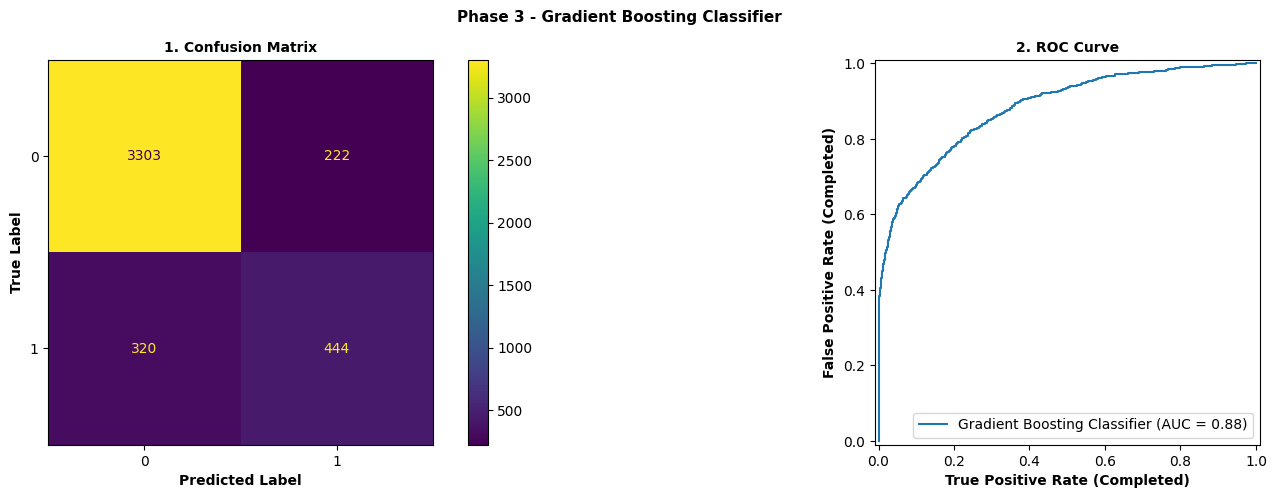

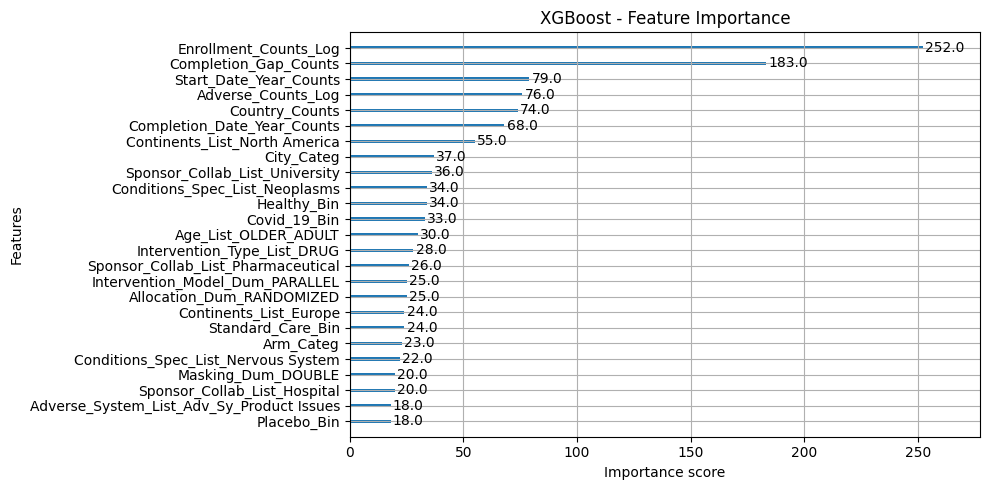

In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric = 'logloss',  # avoids warning
    random_state = 42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]}

xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose = 1)

xg_boost_model = xgb_grid.fit(X_train, y_train)

print("Best Parameters:", xg_boost_model.best_params_)
# print("Best Estimator:", xg_boost_model.best_estimator_) # too long output. 

y_pred = xg_boost_model.predict(X_test)

accuracy(dfi, i, xg_boost_model, X_test, y_test, y_pred_gra_boost, "Gradient Boosting Classifier")

# Plot
fig, ax = plt.subplots(figsize = (10, 5))
plot_importance(xg_boost_model.best_estimator_ , max_num_features=25, ax=ax)
plt.title("XGBoost - Feature Importance")
plt.tight_layout()
plt.show()

# ROC Curve

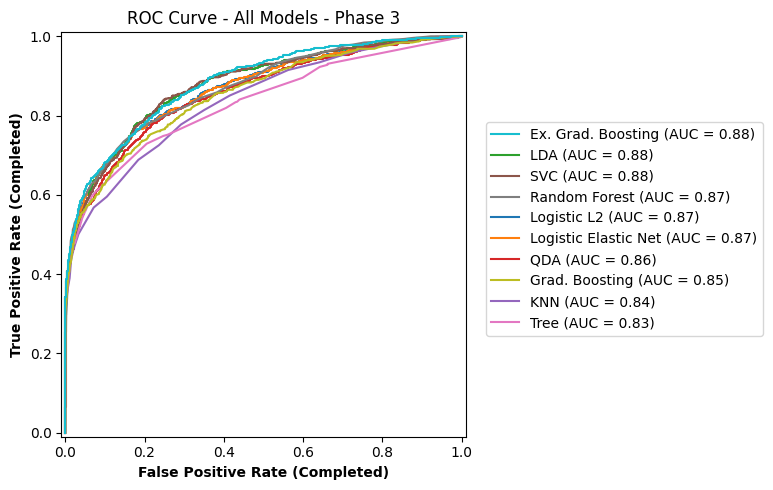

In [ ]:
models = [
    ("Logistic L2", log_model, X_test_log),
    ("Logistic Elastic Net", log_el_model, X_test_el),
    ("LDA", lda_model, X_test_lda),
    ("QDA", qda_model, X_test_qda),
    ("KNN", knn_model, X_test_knn),
    ("SVC", svc_model, X_test_svc),
    ("Tree", tree_model, X_test_tr),
    ("Random Forest", forest_model, X_test_rf),
    ("Grad. Boosting", gra_boost_model, X_test_gb),
    ("Ex. Grad. Boosting", xg_boost_model, X_test_xgb)
]

fig = plt.figure(figsize = (10, 5))
ax = plt.gca()

aucs = []
for original_name, model, X_test_model in models:
    y_score = model.predict_proba(X_test_model)[:, 1] \
        if hasattr(model, "predict_proba") \
            else model.decision_function(X_test_model)
    
    auc = roc_auc_score(y_test, y_score)
    label = f"{original_name} (AUC = {auc:.2f})"
    roc = RocCurveDisplay.from_estimator(model, X_test_model, y_test, ax=ax, name=label, pos_label=1)
    aucs.append((auc, label, roc.line_))

aucs.sort(key=lambda x: x[0], reverse=True)
sorted_handles = [item[2] for item in aucs]  
sorted_labels = [item[1] for item in aucs]   

ax.legend(sorted_handles, sorted_labels, loc=[1.05, 0.25])

ax.set_xlabel("False Positive Rate (Completed)", fontsize=10, fontweight='bold')
ax.set_ylabel("True Positive Rate (Completed)", fontsize=10, fontweight='bold')
plt.title(f"ROC Curve - All Models - Phase {i}") 
plt.tight_layout()
plt.show()
